In [1]:
%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip install pomegranate

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *
import os
import math
from IPython.display import HTML
from IPython.display import Video

from scipy.signal import deconvolve
import pomegranate
from pomegranate import *

import json


In [5]:
def create_burst_trace(
        kon,
        koff,
        duration,
        polymerase_loading_rate,
        polymerase_transit_time,
    ):
    
    on_exp = expon(loc=0,scale=1/kon)
    off_exp = expon(loc=0,scale=1/koff)
    
    output = np.zeros((3,duration))
    
    time = 0
    promoter_state = 0
    
    while time < duration:
        
        if promoter_state == 0:
            off_interval = on_exp.rvs()
            
            promoter_state = 1
            time += off_interval

        else:
            on_interval = off_exp.rvs()
            
            
            tsm = math.modf(time)
            tem = math.modf(time + on_interval)
            
            if tsm[0] <= .5:
                t_start = tsm[1]
            else:
                t_start = tsm[1] + 1    
            if tem[0] >= .5:
                t_end = tem[1] + 1
            else:
                t_end = tem[1]
            t_end = np.min([t_end,duration])
            
            np.put(output[0],np.arange(int(t_start),int(t_end)),1)
            
            time += on_interval
            promoter_state = 0
            
    cv = np.convolve(output[0],polymerase_loading_rate * np.ones(polymerase_transit_time))
    output[1] = cv[0:duration]
    output[2] = output[1] + norm.rvs(loc=0,scale=.5,size=duration)
    return output

def create_burst_traces(
    kon = 1/40,
    koff = 1/20,
    duration = 1000,
    polymerase_loading_rate = .2,
    polymerase_transit_time = 30,
    n = 100
    ):

    output = []
    
    for i in range(0,n):
        output.append(
            create_burst_trace(
                kon=kon,
                koff=koff,
                duration=duration,
                polymerase_loading_rate=polymerase_loading_rate,
                polymerase_transit_time=polymerase_transit_time            
            ))
    
    return np.array(output)
    

In [6]:
kon = 1/100
koff = 1/30
duration = 1000
polymerase_loading_rate = .2
polymerase_transit_time = 30

bursts = create_burst_traces(
    kon=kon,
    koff=koff,
    duration=duration,
    polymerase_loading_rate=polymerase_loading_rate,
    polymerase_transit_time=polymerase_transit_time      
)

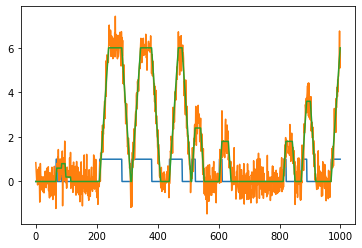

In [7]:
burst = bursts[0]

plt.plot(burst[0])
plt.plot(burst[2])
plt.plot(burst[1])

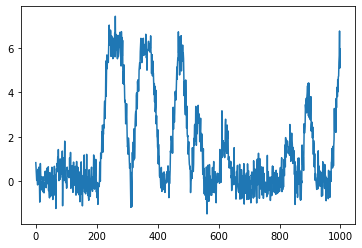

In [8]:
burst = bursts[0]

plt.plot(burst[2])

In [9]:
bursts.shape

(100, 3, 1000)

In [10]:
l = len(burst[0])

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)

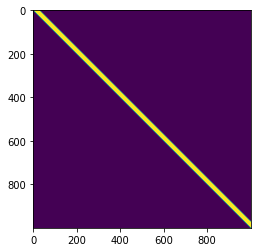

In [11]:
plt.imshow(basis)

In [12]:
burst = bursts[0]

poly_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst[2])[0] / polymerase_loading_rate,np.ones(5)/5)[0:duration]

(array([676.,  33.,  19.,  16.,  12.,  13.,  23.,  29.,  25.,  23.,  19.,
         26.,  19.,  17.,  19.,  13.,  11.,   4.,   1.,   2.]),
 array([0.        , 0.09278031, 0.18556061, 0.27834092, 0.37112123,
        0.46390153, 0.55668184, 0.64946215, 0.74224245, 0.83502276,
        0.92780306, 1.02058337, 1.11336368, 1.20614398, 1.29892429,
        1.3917046 , 1.4844849 , 1.57726521, 1.67004552, 1.76282582,
        1.85560613]),
 <BarContainer object of 20 artists>)

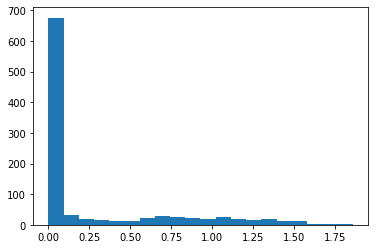

In [13]:
plt.hist(poly_nnls,bins=20)

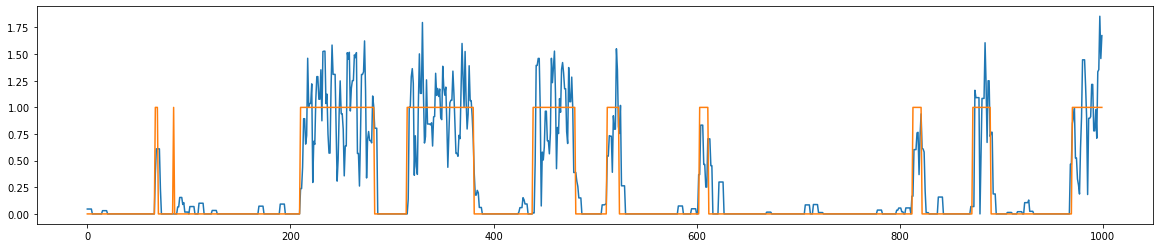

In [14]:
plt.figure(figsize=(20,4))
plt.plot(poly_nnls)
plt.plot(burst[0])

In [15]:
d_off = NormalDistribution(0,.15)
d_on  = NormalDistribution(1,.20)

s_off = State(d_off, name="OFF")
s_on  = State(d_on,  name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

In [16]:
hmm_out = hmm.predict(poly_nnls, algorithm='viterbi')

(0.0, 200.0)

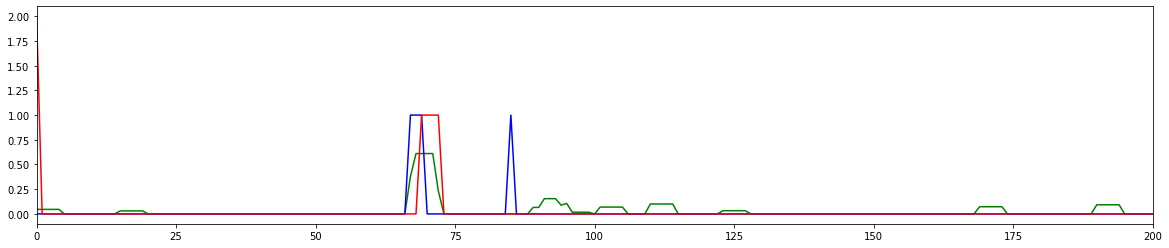

In [17]:
plt.figure(figsize=(20,4))
plt.plot(poly_nnls,c='green')
plt.plot(burst[0],c='blue')
plt.plot(hmm_out,c='red')
plt.xlim(0,200)

In [18]:
poly_nnls = np.zeros((len(bursts),duration))

for i,burst in enumerate(bursts):
    poly_nnls[i] = np.convolve(scipy.optimize.nnls(basis.T,burst[2])[0] / polymerase_loading_rate,np.ones(5)/5)[0:duration]

In [19]:
kon = 1/40
koff = 1/20

kon = 1/100
koff = 1/100

d_off = NormalDistribution(0,.25)
d_on = NormalDistribution(1,.25)

s_off = State(d_off, name="OFF")
s_on = State(d_on, name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [20]:
hmm_out = np.zeros((len(bursts),duration))

for i, burst in enumerate(bursts):
    hmm_out[i] = hmm.predict(poly_nnls[i], algorithm='viterbi')[1:]

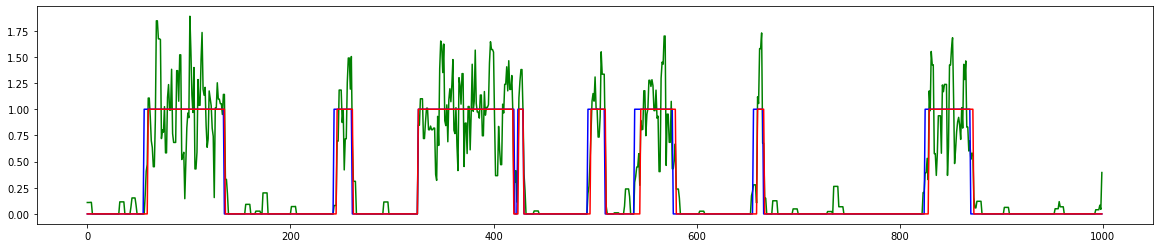

In [21]:
i = 13

plt.figure(figsize=(20,4))
plt.plot(poly_nnls[i],c='green')
plt.plot(bursts[i][0],c='blue')
plt.plot(hmm_out[i],c='red')

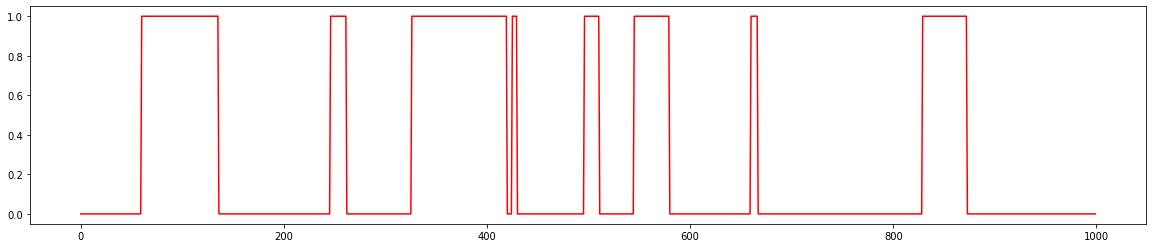

In [22]:
i = 13

plt.figure(figsize=(20,4))
plt.plot(hmm_out[i],c='red')

In [23]:
h = hmm_out[13]

for i in range(0,len(h)-1):
    if h[i] == 0 and h[i+1] == 1:
        print (i)

59
245
325
424
495
544
659
828


In [24]:
[i for i in range(0,len(h)-1) if h[i] == 0 and h[i+1] == 1]

[59, 245, 325, 424, 495, 544, 659, 828]

In [25]:
d = h[1:] - h[0:-1]
np.where(d==1)

(array([ 59, 245, 325, 424, 495, 544, 659, 828]),)

In [26]:
count = 0

for h in hmm_out:
    starts = [i for i in range(0,len(h)-1) if h[i] == 0 and h[i+1] == 1]
    count += len(starts)
    
print (count)

784


In [27]:
count = 0

for h in bursts[:,0]:
    starts = [i for i in range(0,len(h)-1) if h[i] == 0 and h[i+1] == 1]
    count += len(starts)
    
print (count)

775


In [28]:
np.sum(hmm_out)/100

213.46

In [29]:
np.sum(bursts[:,0])/100

225.24

In [30]:
hmm_fit = hmm.fit(poly_nnls,algorithm='viterbi')

In [31]:
hmm_fit_dict = json.loads(hmm.to_json())

In [32]:
hmm_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.99, 0.99, None],
 [0, 1, 0.010000000000000007, 0.01, None],
 [1, 1, 0.99, 0.99, None],
 [1, 0, 0.010000000000000007, 0.01, None]]

In [33]:
hmm_fit_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9491145669095314, 0.99, None],
 [0, 1, 0.050885433090468536, 0.01, None],
 [1, 1, 0.9244078997149847, 0.99, None],
 [1, 0, 0.07559210028501526, 0.01, None]]

In [34]:
hmm_out_fit = np.zeros((len(bursts),duration))

for i, burst in enumerate(bursts):
    hmm_out_fit[i] = hmm.predict(poly_nnls[i], algorithm='viterbi')[1:]

In [35]:
def score_hmm(data_in,data_out):
    a = data_in.flatten()
    b = data_out.flatten()

    print ("1:1",len(np.where(a+b==2)[0]))
    print ("1:0",len(np.where(a-b==1)[0]))
    print ("0:1",len(np.where(b-a==1)[0]))
    print ("0:0",len(np.where(a+b==0)[0]))

In [36]:
score_hmm(bursts[:,0],hmm_out)

1:1 20190
1:0 2334
0:1 1156
0:0 76320


In [37]:
score_hmm(bursts[:,0],hmm_out_fit)

1:1 22160
1:0 364
0:1 17556
0:0 59920


In [38]:
kon = 0.057277486910994775
koff = 0.05110258868648132

ave_on_time = (1/kon) / ( (1/kon) + (1/koff) )
print (ave_on_time)

0.47151276103807566


In [39]:
hmm_fit = hmm.fit(poly_nnls,algorithm='baum-welch')

In [40]:
hmm_fit_dict = json.loads(hmm.to_json())

In [41]:
hmm_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.99, 0.99, None],
 [0, 1, 0.010000000000000007, 0.01, None],
 [1, 1, 0.99, 0.99, None],
 [1, 0, 0.010000000000000007, 0.01, None]]

In [42]:
hmm_fit_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9500670262980011, 0.99, None],
 [0, 1, 0.0499329737019988, 0.01, None],
 [1, 1, 0.9260883116716783, 0.99, None],
 [1, 0, 0.07391168832832175, 0.01, None]]

In [43]:
hmm_out_fit = np.zeros((len(bursts),duration))

for i, burst in enumerate(bursts):
    hmm_out_fit[i] = hmm.predict(poly_nnls[i], algorithm='viterbi')[1:]

In [44]:
score_hmm(bursts[:,0],hmm_out_fit)

1:1 22160
1:0 364
0:1 17552
0:0 59924
